In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

np.random.seed(42)
tf.random.set_seed(42)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
else:
    print("No GPU available.")

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


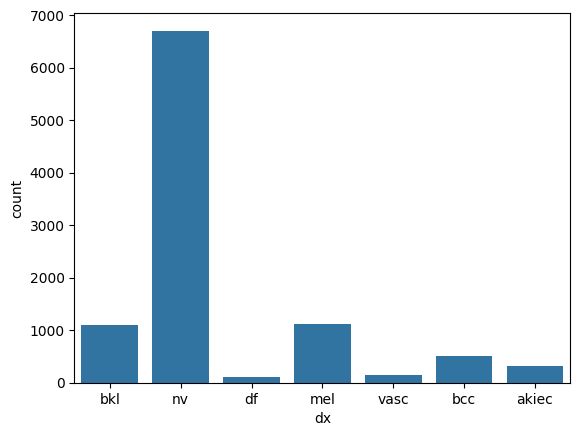

In [11]:
data_path = 'data/ham10000/HAM10000_metadata.csv'
df = pd.read_csv(data_path)

image_dir = 'data/ham10000/images/'  

df['image_path'] = image_dir + df['image_id'] + '.jpg'

df.head()

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])

sns.countplot(x='dx', data=df)
plt.show()

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)


In [12]:
print(train_df['label'].unique())  
print(val_df['label'].unique())    
print(test_df['label'].unique())   

[4 0 3 5 2 6 1]
[5 2 1 0 4 3 6]
[5 4 2 1 3 0 6]


In [13]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)


In [14]:
image_size = (64, 64)  
batch_size = 128

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 7210 validated image filenames belonging to 7 classes.
Found 802 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [15]:
class CustomCNN(models.Model):
    def __init__(self, layers_list):
        super(CustomCNN, self).__init__()
        self.model = models.Sequential()
        for layer in layers_list:
            self.model.add(layer)
    
    def call(self, inputs):
        return self.model(inputs)

def create_custom_cnn(input_shape, num_classes, conv_filters, dropout_rate):
    layers_list = [
        layers.Input(input_shape),
        layers.Conv2D(conv_filters, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(2 * conv_filters, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(4 * conv_filters, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ]
    
    model = CustomCNN(layers_list)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [16]:
input_shape = (64, 64, 3)  
num_classes = len(df['label'].unique())

def optimize_model(params):
    conv_filters = params[0]  
    dropout_rate = params[1]  

    model = create_custom_cnn(input_shape, num_classes, conv_filters, dropout_rate)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5,  
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator),
        verbose=0  
    )
    
    val_loss = history.history['val_loss'][-1]  
    return val_loss  

from skopt.space import Integer, Real

search_space = [
    Integer(16, 128, name='conv_filters'),  
    Real(0.1, 0.5, name='dropout_rate')      
]

from skopt import gp_minimize

result = gp_minimize(optimize_model, search_space, n_calls=20, random_state=42)

print("Best parameters found: Conv Filters: {}, Dropout Rate: {}".format(result.x[0], result.x[1]))
print("Best validation loss: {}".format(result.fun))

final_model = create_custom_cnn((64, 64, 3), num_classes, result.x[0], result.x[1])

final_model.fit(train_generator, validation_data=val_generator, epochs=5)

I0000 00:00:1728674794.138360   23827 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728674794.138453   23827 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728674794.138493   23827 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728674794.281560   23827 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728674794.281674   23827 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-11

Best parameters found: Conv Filters: 105, Dropout Rate: 0.17337391594646553
Best validation loss: 0.8836966156959534
Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 482ms/step - accuracy: 0.6243 - loss: 1.2201 - val_accuracy: 0.6696 - val_loss: 0.9927
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 431ms/step - accuracy: 0.6749 - loss: 0.9903 - val_accuracy: 0.6696 - val_loss: 0.9536
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 482ms/step - accuracy: 0.6656 - loss: 0.9638 - val_accuracy: 0.6733 - val_loss: 0.9083
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 491ms/step - accuracy: 0.6606 - loss: 0.9532 - val_accuracy: 0.6758 - val_loss: 0.8860
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 478ms/step - accuracy: 0.6621 - loss: 0.9097 - val_accuracy: 0.6920 - val_loss: 0.8275


/home/bosa/manu/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 527ms/step - accuracy: 0.7023 - loss: 0.8071
Test Accuracy: 0.6984522938728333
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step
ROC AUC Score: 0.5214632566986713
F1 Score: 0.522835045607017


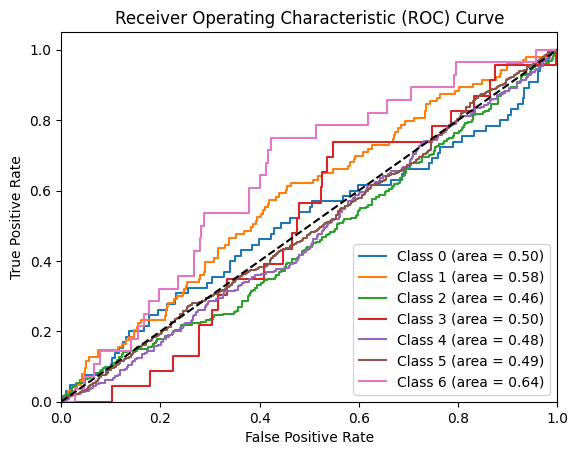

In [18]:
test_loss, test_acc = final_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc}')


y_true = test_df['label'].astype(int)
y_pred_prob = final_model.predict(test_generator)
y_pred = y_pred_prob.argmax(axis=1)


roc_auc = roc_auc_score(to_categorical(y_true), y_pred_prob)
print(f'ROC AUC Score: {roc_auc}')


f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')


fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true)[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()